In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [ ]:
ROOT = '.data'

train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 11987888.40it/s]


Extracting .data/MNIST/raw/train-images-idx3-ubyte.gz to .data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 350630.12it/s]


Extracting .data/MNIST/raw/train-labels-idx1-ubyte.gz to .data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3197487.92it/s]


Extracting .data/MNIST/raw/t10k-images-idx3-ubyte.gz to .data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3208780.32it/s]

Extracting .data/MNIST/raw/t10k-labels-idx1-ubyte.gz to .data/MNIST/raw



In [ ]:
mean = train_data.data.float().mean()/255
std = train_data.data.float().std()/255
mean, std

(tensor(0.1307), tensor(0.3081))

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomRotation(5, fill=(0,)),
    transforms.RandomCrop(28, padding=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

In [ ]:
train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transform)
test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transform)
train_data, test_data

(Dataset MNIST
     Number of datapoints: 60000
     Root location: .data
     Split: Train
     StandardTransform
 Transform: Compose(
                RandomRotation(degrees=[-5.0, 5.0], interpolation=nearest, expand=False, fill=(0,))
                RandomCrop(size=(28, 28), padding=2)
                ToTensor()
                Normalize(mean=[tensor(0.1307)], std=[tensor(0.3081)])
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: .data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=[tensor(0.1307)], std=[tensor(0.3081)])
            ))

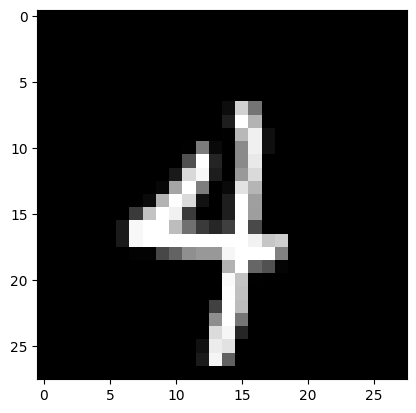

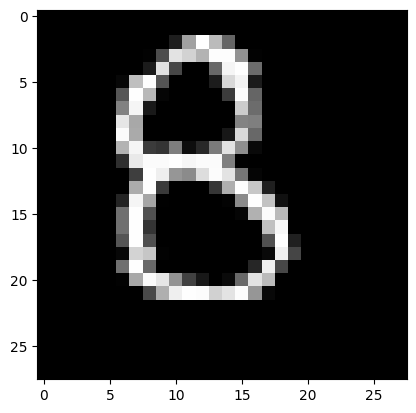

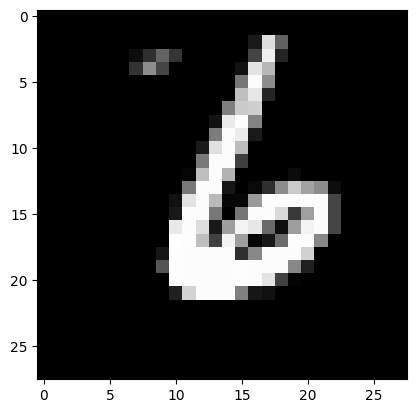

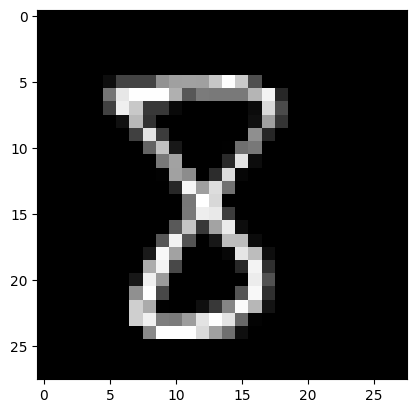

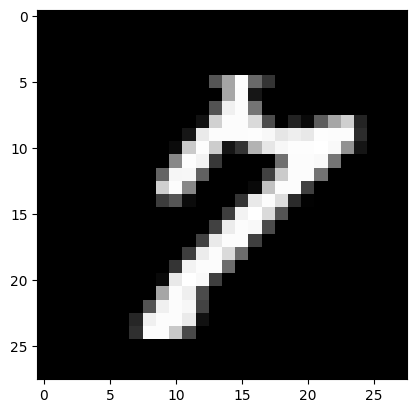

In [ ]:
imgs = [image for image, label in [train_data[i] for i in range(5)]]
for img in imgs:
    plt.imshow(img.squeeze(), cmap='gray')
    plt.show()

In [ ]:
valid_size = 0.9
n_train_data = int(len(train_data)*valid_size)
n_valid_data = len(train_data) - n_train_data
train_data, valid_data = data.random_split(train_data, [n_train_data, n_valid_data])
len(train_data), len(valid_data)

(48600, 5400)

In [ ]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transform
len(valid_data)

5400

In [ ]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

In [ ]:
class MLP(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(MLP, self).__init__()
    self.input_func = nn.Linear(input_dim, 250)
    self.hidden_func = nn.Linear(250, 100)
    self.output_func = nn.Linear(100, output_dim)

  def forward(self, x):
    batch_size = x.shape[0]
    x = x.view(batch_size, -1)
    h_1 = F.relu(self.input_func(x))
    h_2 = F.relu(self.hidden_func(h_1))
    pred = self.output_func(h_2)
    return pred, h_2

In [ ]:
model = MLP(28*28, 10)
model

MLP(
  (input_func): Linear(in_features=784, out_features=250, bias=True)
  (hidden_func): Linear(in_features=250, out_features=100, bias=True)
  (output_func): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def caculate_acuracy(y_pred, y):
  top_pred = y_pred.argmax(1, keepdim=True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float()/y.shape[0]
  return acc


In [ ]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  model.train()

  for (x, y) in tqdm(iterator, desc='Training', leave= False):
    x = x.to(device)
    y = y.to(device)
    optimizer.zero_grad()
    y_pred, _ = model(x)
    loss = criterion(y_pred, y)
    acc = caculate_acuracy(y_pred, y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  model.eval()
  with torch.no_grad():
    for (x, y) in tqdm(iterator, desc='Evaluating', leave= False):
      x = x.to(device)
      y = y.to(device)
      y_pred, _ = model(x)
      loss = criterion(y_pred, y)
      acc = caculate_acuracy(y_pred, y)
      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time/60)
  elapsed_secs = int(elapsed_time - (elapsed_mins*60))
  return elapsed_mins, elapsed_secs

In [ ]:
best_valid_loss = float('inf')

for epoch in trange(25):
  start_time = time.monotonic()
  train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'tut1-model.pt')

  end_time = time.monotonic()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


  0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 44s
	Train Loss: 0.399 | Train Acc: 87.62%
	 Val. Loss: 0.193 |  Val. Acc: 93.98%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 43s
	Train Loss: 0.167 | Train Acc: 94.89%
	 Val. Loss: 0.134 |  Val. Acc: 95.94%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 44s
	Train Loss: 0.129 | Train Acc: 96.04%
	 Val. Loss: 0.110 |  Val. Acc: 96.69%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 43s
	Train Loss: 0.115 | Train Acc: 96.42%
	 Val. Loss: 0.100 |  Val. Acc: 97.08%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 43s
	Train Loss: 0.103 | Train Acc: 96.80%
	 Val. Loss: 0.095 |  Val. Acc: 97.28%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 43s
	Train Loss: 0.096 | Train Acc: 96.93%
	 Val. Loss: 0.080 |  Val. Acc: 97.37%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 43s
	Train Loss: 0.090 | Train Acc: 97.24%
	 Val. Loss: 0.072 |  Val. Acc: 97.78%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 43s
	Train Loss: 0.085 | Train Acc: 97.34%
	 Val. Loss: 0.071 |  Val. Acc: 97.92%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 43s
	Train Loss: 0.081 | Train Acc: 97.50%
	 Val. Loss: 0.071 |  Val. Acc: 97.81%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 44s
	Train Loss: 0.076 | Train Acc: 97.62%
	 Val. Loss: 0.075 |  Val. Acc: 97.74%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 44s
	Train Loss: 0.074 | Train Acc: 97.76%
	 Val. Loss: 0.062 |  Val. Acc: 98.03%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 44s
	Train Loss: 0.074 | Train Acc: 97.71%
	 Val. Loss: 0.079 |  Val. Acc: 97.78%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 43s
	Train Loss: 0.071 | Train Acc: 97.75%
	 Val. Loss: 0.059 |  Val. Acc: 98.31%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 43s
	Train Loss: 0.068 | Train Acc: 97.89%
	 Val. Loss: 0.062 |  Val. Acc: 98.05%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 43s
	Train Loss: 0.068 | Train Acc: 97.89%
	 Val. Loss: 0.061 |  Val. Acc: 98.11%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 44s
	Train Loss: 0.064 | Train Acc: 98.01%
	 Val. Loss: 0.060 |  Val. Acc: 98.00%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 44s
	Train Loss: 0.065 | Train Acc: 97.95%
	 Val. Loss: 0.057 |  Val. Acc: 98.24%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 44s
	Train Loss: 0.062 | Train Acc: 98.06%
	 Val. Loss: 0.056 |  Val. Acc: 98.35%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 43s
	Train Loss: 0.060 | Train Acc: 98.13%
	 Val. Loss: 0.059 |  Val. Acc: 98.19%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 44s
	Train Loss: 0.059 | Train Acc: 98.15%
	 Val. Loss: 0.052 |  Val. Acc: 98.55%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 21 | Epoch Time: 0m 44s
	Train Loss: 0.058 | Train Acc: 98.19%
	 Val. Loss: 0.052 |  Val. Acc: 98.46%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 22 | Epoch Time: 0m 44s
	Train Loss: 0.055 | Train Acc: 98.28%
	 Val. Loss: 0.050 |  Val. Acc: 98.44%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 23 | Epoch Time: 0m 45s
	Train Loss: 0.056 | Train Acc: 98.31%
	 Val. Loss: 0.049 |  Val. Acc: 98.44%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 24 | Epoch Time: 0m 44s
	Train Loss: 0.055 | Train Acc: 98.31%
	 Val. Loss: 0.052 |  Val. Acc: 98.55%


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 25 | Epoch Time: 0m 44s
	Train Loss: 0.052 | Train Acc: 98.31%
	 Val. Loss: 0.046 |  Val. Acc: 98.53%


### Examining

In [ ]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(model, test_iterator, device)
pred_label = probs.argmax(dim=1)
pred_label

tensor([7, 2, 1,  ..., 4, 5, 6])

In [ ]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

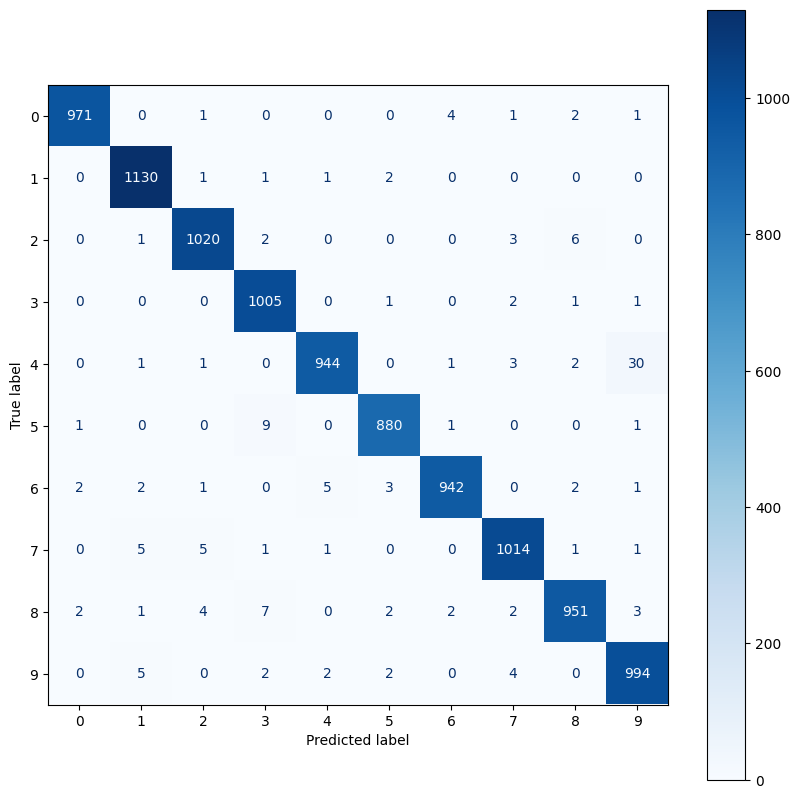

In [ ]:
plot_confusion_matrix(labels=labels, pred_labels=pred_label)